<a href="https://colab.research.google.com/github/jafr0822/MNA_ProyectoIntegrador-Equipo7/blob/main/Avance3_7_Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Integrador


## Tecnológico de Monterrey
### Maestría en Inteligencia Artificial Aplicada (MNA)
#### Avance 3
#### Equipo 7


* Jorge Arturo Federico Rivera – A01250724
* Marco Antonio Vázquez Morales – A01793704
* Alejandro Jesús Vázquez Navarro - A01793146

### Baseline

Proyecto:

*Modelo clasificador de multimorbilidad maternal y predictor de desenlaces perinatales a partir de datos clínicos metabólicos, genéticos y nutricionales de mujeres mexicanas*

19 de mayo de 2024

# 1. Algoritmo

El problema escogido será tratado como aprendizaje supervisado. Nos enfocaremos en la predicción de una variable dependiente "EscalaRiesgo" que contendrá 3 valores:
- A. Para alto riesgo (la presencia de 3 o 4 factores multimorbilidad)
- B. Para medio riesgo (presencia de 1 o 2 factores multimorbilidad)
- C. Para riesgo nulo. (sin la presencia de factores de multimorbilidad)

En esta entrega utilizaremos un algoritmo de **Random Forest** por las siguientes causas:
- **Precisión**. Los árboles de bosque aleatorios proporcionan buenos resultados cuando tenemos datos con muchas características.
- **Manejo del sobreajuste.** Mediante el promedio de los resultados de los árboles, los bosques aleatorios reducen el riesgo de sobreajuste en comparación con un único árbol de decisión.
- **Heterogeneidad.** Funcionan muy buen con datos tanto numéricos como categóricos
- Son mucho menos sensibles a datos ruidosos.
- **Generalización.** Dan muy buenos resultados en térrminos de generalización para nuevas observaciones


##1.1 Carga de librerías

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

##1.2 Carga de datos limpios

In [ ]:

file_path = r'data/data_limpia.csv'

#Eliminamos columnas que no necesitaremos como identificarores y el número de clúster

cols_to_remove = ['id_gdg', 'origen_px', 'IndexMorbilidad', 'anticonceptivo_0.0',
       'anticonceptivo_0.6316526610644257', 'anticonceptivo_1.0',
       'anticonceptivo_2.0', 'cluster']

data = pd.read_csv(file_path, sep=";", encoding='utf-8')
data  = data.drop(cols_to_remove , axis=1)

data.head()


,EscalaRiesgo,biopsias,obs_h,ichos_pregesta,hta_pregesta,sop,hipotiroidismo,hipertiroidismo,consumo_alcohol,consumo_tabaco,...,sdg_parto,ant_aborto,macrosomia_rn_0,macrosomia_rn_0.0,macrosomia_rn_0/0,macrosomia_rn_1,macrosomia_rn_1.0,macrosomia_rn_1/0,macrosomia_rn_1/1,macrosomia_rn_2
0,C,0,0,0,0,0,0,0,0,0,...,0.0,-0.747297,0,0,0,1,0,0,0,0
1,C,0,0,0,1,0,0,0,0,0,...,0.0,-0.747297,0,0,0,1,0,0,0,0
2,C,0,1,0,1,0,0,0,0,0,...,0.0,-0.747297,0,0,0,1,0,0,0,0
3,B,0,0,0,1,0,0,0,0,0,...,0.0,-0.747297,0,0,0,1,0,0,0,0
4,C,0,1,0,1,0,0,0,0,0,...,0.0,1.420203,0,0,0,1,0,0,0,0


###1.2.1 Inspección rápida de la data cargada

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
biopsias,1370.0,0.075912,0.264955,0.0,0.0,0.0,0.0,1.0
obs_h,1370.0,0.182482,0.386382,0.0,0.0,0.0,0.0,1.0
ichos_pregesta,1370.0,0.017518,0.131240,0.0,0.0,0.0,0.0,1.0
hta_pregesta,1370.0,0.118248,0.323020,0.0,0.0,0.0,0.0,1.0
sop,1370.0,0.016058,0.125746,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
macrosomia_rn_1,1370.0,0.927007,0.260220,0.0,1.0,1.0,1.0,1.0
macrosomia_rn_1.0,1370.0,0.002920,0.053975,0.0,0.0,0.0,0.0,1.0
macrosomia_rn_1/0,1370.0,0.000730,0.027017,0.0,0.0,0.0,0.0,1.0
macrosomia_rn_1/1,1370.0,0.008029,0.089278,0.0,0.0,0.0,0.0,1.0


In [ ]:
data.isnull().sum()

EscalaRiesgo         0
biopsias             0
obs_h                0
ichos_pregesta       0
hta_pregesta         0
                    ..
macrosomia_rn_1      0
macrosomia_rn_1.0    0
macrosomia_rn_1/0    0
macrosomia_rn_1/1    0
macrosomia_rn_2      0
Length: 82, dtype: int64

## 1.3 Generación de holdout set

In [ ]:
X = data.drop('EscalaRiesgo', axis=1)
y = data['EscalaRiesgo']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 1.4 Entrenamiento del algoritmo

In [ ]:
# 3. Evaluate the main features towards EscalaRiesgo using RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# 2. Características Importantes

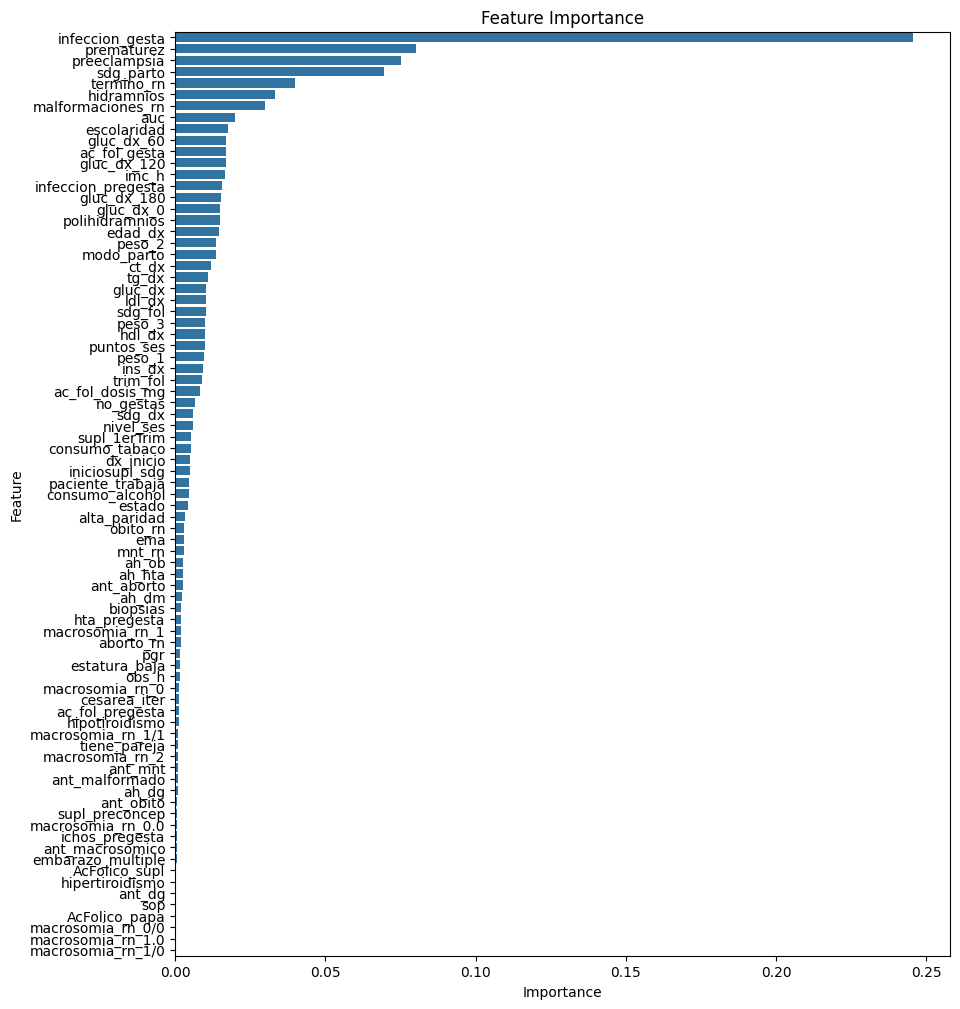

In [ ]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##2.1 Evaluación con observaciones no vistas


In [ ]:

y_pred = model.predict(X_holdout)
print(classification_report(y_holdout, y_pred))



              precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.96      1.00      0.98        89
           C       1.00      0.99      1.00       182

    accuracy                           0.99       274
   macro avg       0.65      0.66      0.66       274
weighted avg       0.98      0.99      0.98       274



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A primera vista, nuestro modelo puede estar sobreajustado. No tenemos valores superiores a 0 en precisión y recall por lo tanto el F1-Score cae a valores de **0.66**

No tener valores en precisión y recall además de una F1-Score en .66 son nuestras métricas base para afinar el modelo.

#3. Sub / Sobreajuste

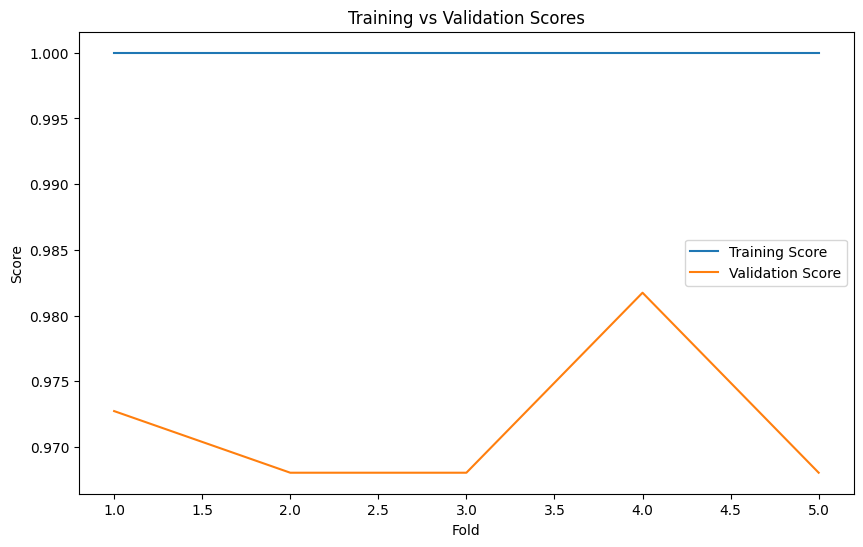

In [ ]:
train_scores = []
val_scores = []

cv = 5
for train_idx, val_idx in StratifiedKFold(n_splits=cv).split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(X_cv_train, y_cv_train)

    train_score = model.score(X_cv_train, y_cv_train)
    val_score = model.score(X_cv_val, y_cv_val)

    train_scores.append(train_score)
    val_scores.append(val_score)

plt.figure(figsize=(10, 6))
plt.plot(range(1, cv+1), train_scores, label='Training Score')
plt.plot(range(1, cv+1), val_scores, label='Validation Score')
plt.title('Training vs Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

Tenemos un modelo sobreajustado, el modelo ha memorizado las relaciones entrevariables. Esto es claro pues tenemos valores de **1.00** en el entrenamiento y valores de 0.98 en el set de validación. No tenemos generalización.

#4. Métrica

Para este problema de clasificación multiclase, utilizamos classification_report que incluye:
- Precisión: Indica la proporción de identificaciones positivas que fueron realmente correctas.
- Recall: Indica la proporción de positivos reales que fueron identificados correctamente.
- Puntuación F1: Media armónica de la precisión y la recuperación, que proporciona una medida única del rendimiento del modelo.
- Soporte: Número de casos reales de la clase en el conjunto de datos especificado.

La elección de estas métricas nos permite equilibrar la precisión y el recall, proporcionando una evaluación completa del rendimiento del modelo en todas las clases.

Como se mencionó, nuestra **F1-score está en 0.66**

La matriz de confusión soporta lo mal que performa el modelo con la clase **A** (alto riesgo).


## 4.1 Matriz de confusion

Una herramienta vital para el entendimiento del desemeño de nuestro modelo es la matriz de confusión, a continuación se codifica esta funcionalidad.

In [ ]:
print(confusion_matrix(y_holdout, y_pred))


[[  0   3   0]
 [  0  89   0]
 [  0   1 181]]


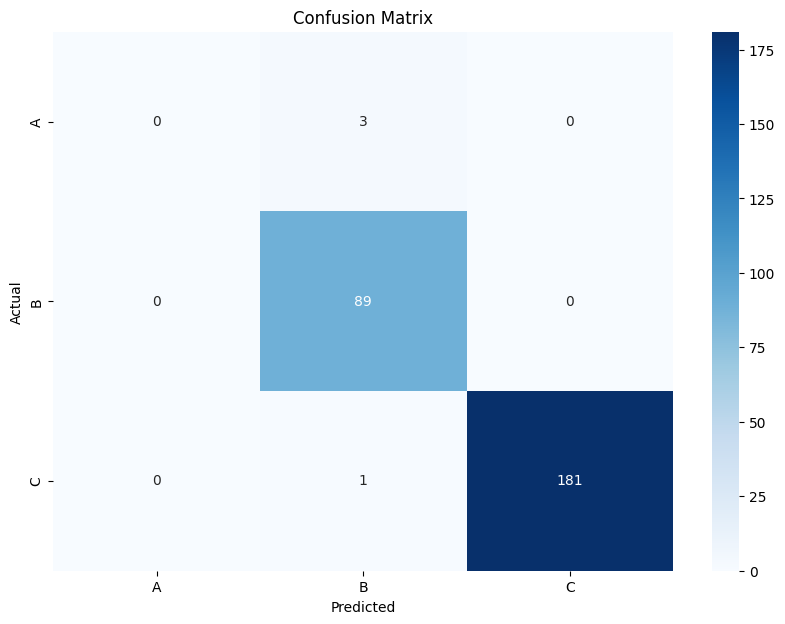

In [ ]:
conf_matrix = confusion_matrix(y_holdout, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Tenemos un desbalanceo de clases notable, la clase A no es predicha en ningún momento. Deberemos tratar esto, en la siguiente fase, con un algoritmo **SMOTE** (Synthetic Minority Over-sampling Technique) y como si fuera un caso de uso de fraude donde el fraude es tratado como una anomalía estadística. Aquí será similar, nos interesa un balanceo uniformne entre clases y no lo tenemos.

Un punto interesante es que ejecutamos un algoritmo SVC y obtuvimos mejores resultados en la matriz de confusión; dicho algoritmo logró predecir correctamente 2 observaciones en la clase A.

Definitivamente incluiremos SVC para la siguiente entrega y lo pondremos a competir vs RandomForest y una Red Neuronal.

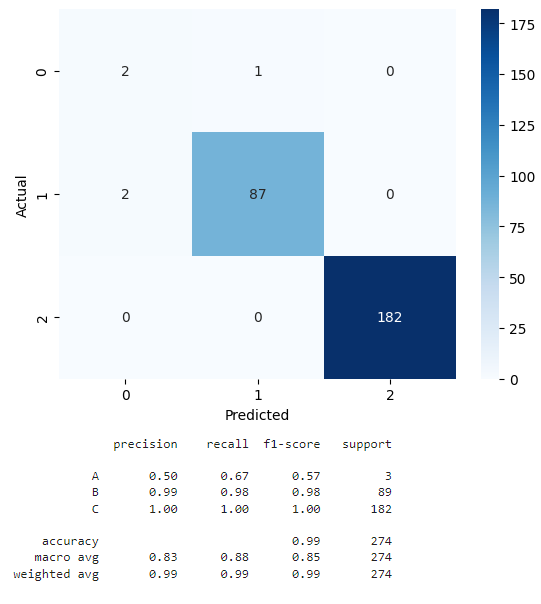

In [ ]:
feature_importances.to_csv('feature_importances.csv', index=True)
pd.DataFrame(classification_report(y_holdout, y_pred, output_dict=True)).to_csv('classification_report.csv', index=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#5. Desempeño

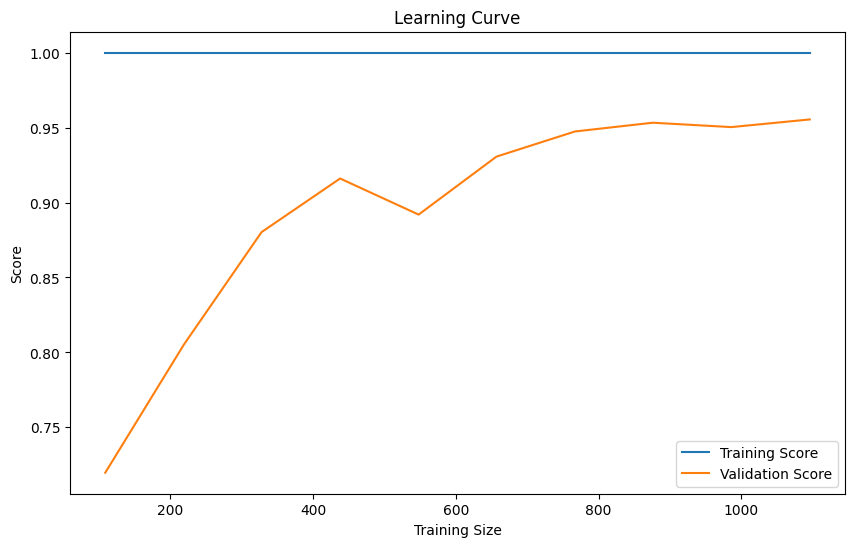

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(random_state=42), X, y, cv=cv, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, val_scores_mean, label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()

Observamos un desempeño sobreajustado. Esto debido a la alta dimensionalidad, el desbalanceo de clases y la falta de hiperparámetros. Como modelo base es aceptable comenzar con un modelo con estas características. Lo importante será afinar, balancear y aplicar diferentes modelos de clasificación y elegir el que devuelva mejores F1-Score y una ROC aceptable.

# Conclusiones

## Despues de realizar el tratamiento de datos, en esta etapa creamos nuestro primer modelo, donde encontramos que estamos ante un conjunto de datos muy complejo.

## Em primer lugar identificamos las variables infeccion_gesta, prematurez,preeclampsia, sdg_parto, termino_rn, hidramnios, malformaciones_rn, auc, escolaridad, gluc_dx_60, ac_fol_gesta, gluc_dx_120, imc_h, infeccion_pregesta, gluc_dx_180, gluc_dx_0, polihidramnios, edad_dx, peso_2, modo_parto, ct_dx,tg_dx, proporcionan un poder acumulado predictivo de __0.80__ puntos, lo que nos indica que estas definitivamente estarán en el modelo, para el resto de las variables tendríamos que analizarlas nuevamente a fin de determinar las que no tienen un impacto signiticativo.

## En segundo lugar, entrenamos tres modelos: Random Forest Classifier, Support Vector Machines y CNN, nos quedamos con Random Forest Classifier, sin embargo analizaremos a profundidad los resultados especificos de los demás, en este caso, tenemos un modelo sobrenetrenado, esto a todas luces se puede detectar cuando tenemos métricas de 1.00 en el training score vs valores .95 en el validación score. Claramente nuestro modelo ha aprendido de los datos de entrenamiento y lo ha memorizado. No queremos esto, queremos generalización, es decir, la adaptación correcta de nuestro modelo a datos no vistos anteriormente extraídos del holdout set.

## Así que en las próximas fases, deberemos realizar afinamiento de hiperparámetros y reducir la dimensionalidad de nuestra dataset incluyendo el análisis de PCA que realizamos entregamos pasadas.

## En tercer lugar observamos que tenemos un desbalance en la variable dependiente EscalaRiesgo para los valores A lo cual obligará realizar un balanceo de clases en la próxima entrega.